In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels import api as sm
import statsmodels

plt.rcParams['figure.figsize'] = 15, 7

                      puissance
date                           
2015-09-13 00:59:59  526.166667
2015-09-13 01:59:59  495.000000
2015-09-13 02:59:59  446.166667
2015-09-13 03:59:59  365.833333
2015-09-13 04:59:59  341.000000


/home/ulysse/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


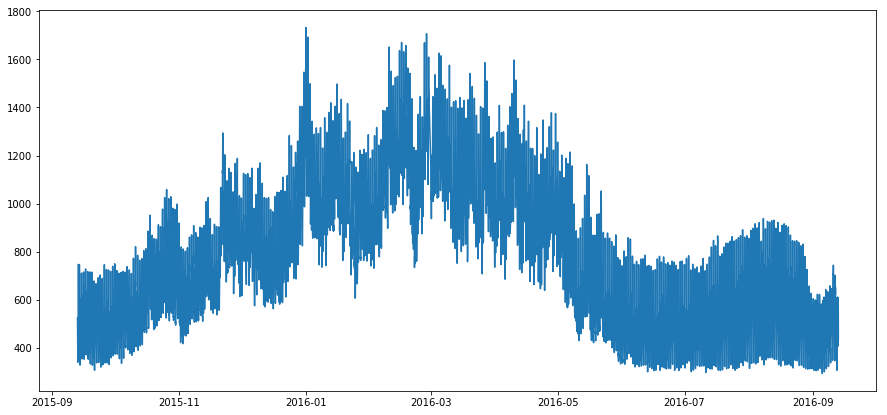

In [3]:
def parser(x):
    x=str(x)[:19]
    return pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')
#cols = read_csv('elec_train.csv',sep=';').columns
df = pd.read_csv('elec_train.csv', sep=';',header=0, parse_dates=[0], index_col=0, squeeze=False, date_parser=parser)
#print(cols)
print(df.head())
#print(list(series['date;puissance']))

plt.plot(df)
plt.show()

## Recherche stationnarité en approximant la tendance

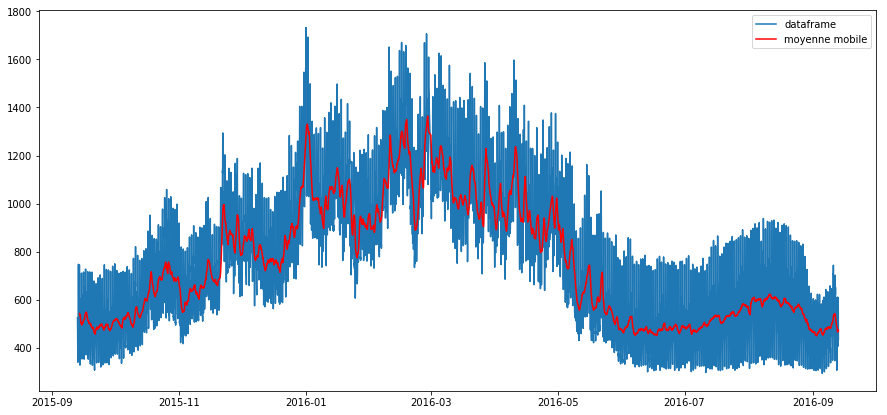

In [4]:
moving_avg = df.rolling(24).mean()
plt.plot(df,label='dataframe')
plt.plot(moving_avg, color='red',label='moyenne mobile')
plt.legend()

In [5]:
moving_avg.dropna(inplace=True)
taille = len(moving_avg.axes[0])
x = np.linspace(0,taille,taille)
y = np.array([moving_avg['puissance'][i] for i in range(taille)])
print(x[3],y[3])
print(type(moving_avg))
approx_ma = np.poly1d(np.polyfit(x,y,5))

3.000343406593407 537.0972222222499
<class 'pandas.core.frame.DataFrame'>


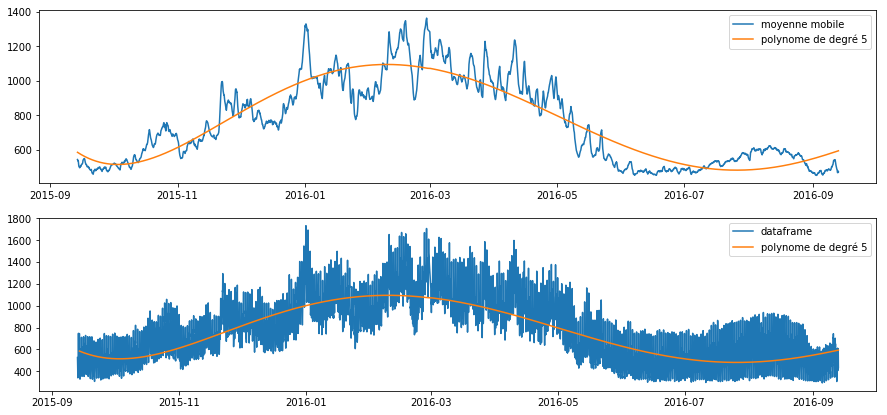

In [6]:
approx_trend = pd.Series(approx_ma(x),moving_avg.axes[0])
approx_trend = approx_trend.to_frame(name='puissance')

plt.subplot(2,1,1)
plt.plot(moving_avg,label='moyenne mobile')
plt.plot(approx_trend,label='polynome de degré 5')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df,label='dataframe')
plt.plot(approx_trend,label='polynome de degré 5')
plt.legend()
plt.show()

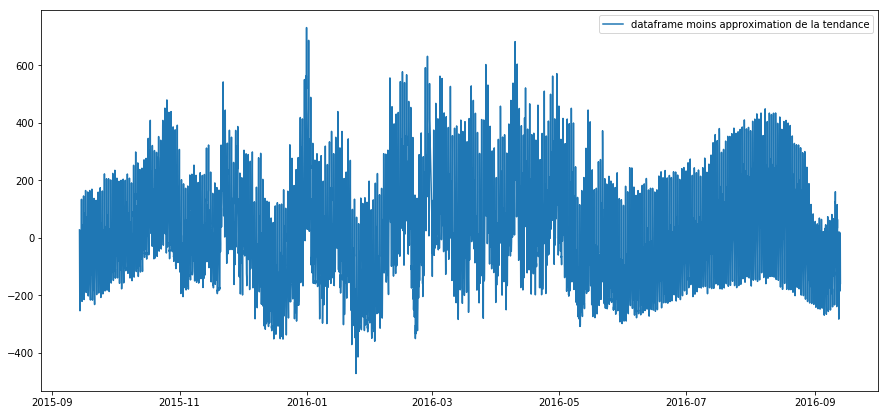

In [7]:
df_trend = df - approx_trend
plt.plot(df_trend,label='dataframe moins approximation de la tendance')
df_trend.dropna(inplace=True)
plt.legend()
plt.show()

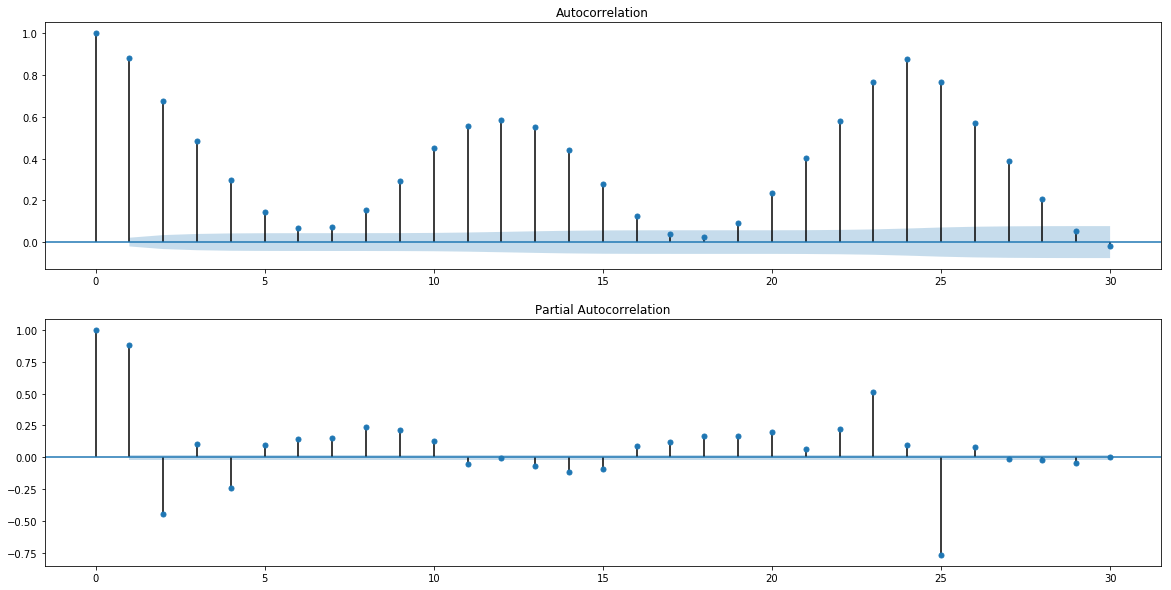

In [8]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df_trend, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_trend, lags=30, ax=ax[1])
plt.show()

In [9]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    forecast_errors = [np.abs((y_true[i]-y_pred[i])/y_true[i]) for i in range(len(y_true))]
    return np.mean(forecast_errors) * 100

# Partie ARMA

In [10]:
#Prend beaucoup de temps 
#-------------------------------------------
from statsmodels.tsa.arima_model import ARIMA
df_train = df_trend[:-24*7]
model = ARIMA(df_train, order=(24,0,23))
results_ARMA = model.fit(disp=1) 
print('fin')

/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


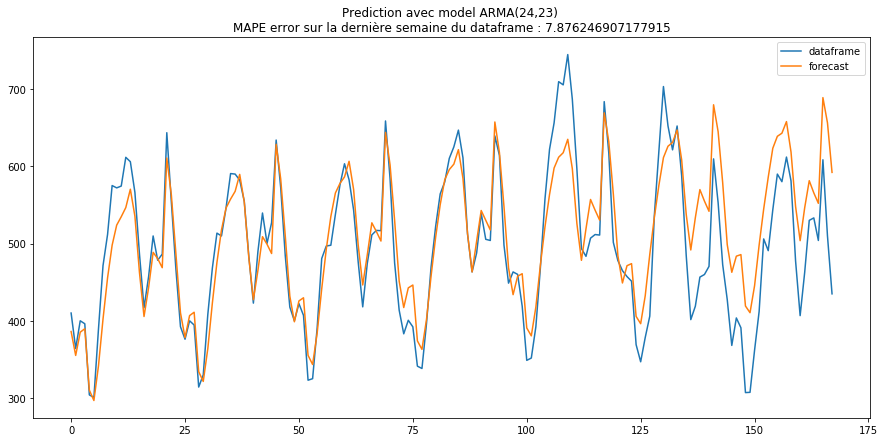

In [48]:
pred = results_ARMA.forecast(24*7)

taille = len(df)
x_pred = np.linspace(taille-24*7,taille,24*7)

vec_trend = approx_ma(x_pred)
predictions_ARMA = np.array(pred[0]) + np.array(vec_trend)
true_value = np.array(df[-(24*7):]['puissance'])

plt.plot(true_value,label='dataframe')
plt.plot(predictions_ARMA,label='forecast')
mape_err = mape(true_value,predictions_ARMA)
plt.title('Prediction avec model ARMA(24,23) \nMAPE error sur la dernière semaine du dataframe : ' +str(mape_err))
plt.legend()
plt.show()

# Partie réseau de neurones

In [10]:
df = df.reset_index(level=['date'])
df.head()

,date,puissance
0,2015-09-13 00:59:59,526.166667
1,2015-09-13 01:59:59,495.000000
2,2015-09-13 02:59:59,446.166667
3,2015-09-13 03:59:59,365.833333
4,2015-09-13 04:59:59,341.000000


In [11]:
df['week-end'] = ((pd.DatetimeIndex(df['date']).dayofweek) // 5 == 1).astype(float)
df['WEEKDAY'] = (pd.DatetimeIndex(df['date']).dayofweek)
df.head()

,date,puissance,week-end,WEEKDAY
0,2015-09-13 00:59:59,526.166667,1.0,6
1,2015-09-13 01:59:59,495.000000,1.0,6
2,2015-09-13 02:59:59,446.166667,1.0,6
3,2015-09-13 03:59:59,365.833333,1.0,6
4,2015-09-13 04:59:59,341.000000,1.0,6


In [14]:
def prepare_data(data_y, step):
    x = []
    y = []
    for i in range(step,len(data_y)):
        x.append(data_y[i-step:i])
        y.append(data_y[i])
    return np.array(x),np.array(y)

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(13)

begin_train_data = 40*24*7 #int(len(df)-24*7-24*7*10)   #On entraine sur 15 semaine car c est ce que l'on a trouvé de mieux
end_train_data = int(len(df)-24*7)


trainer = df['puissance'].values[begin_train_data:end_train_data]
step = 24*3

train_x, train_y = prepare_data(trainer, step)

model = Sequential()
model.add(Dense(10, activation='relu', input_dim=step))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
ADAM = optimizers.Adam(lr=0.001)
model.compile(optimizer=ADAM, loss='mape')

#model.load_weights('weights5percent.hdf5')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath="weights0.hdf5", verbose=0, monitor='loss', save_best_only=True)

history = model.fit(train_x, train_y, batch_size = 10, epochs=300,callbacks = [early_stop,checkpointer], verbose=1)
#model.load_weights('weights0.hdf5')

Epoch 1/300
1800/1800 [==============================] - 1s 332us/step - loss: 18.4954
Epoch 2/300
1800/1800 [==============================] - 0s 88us/step - loss: 8.5131
Epoch 3/300
1800/1800 [==============================] - 0s 84us/step - loss: 7.4013
Epoch 4/300
1800/1800 [==============================] - 0s 80us/step - loss: 6.9549
Epoch 5/300
1800/1800 [==============================] - 0s 93us/step - loss: 6.3076
Epoch 6/300
1800/1800 [==============================] - 0s 81us/step - loss: 6.0432
Epoch 7/300
1800/1800 [==============================] - 0s 81us/step - loss: 5.6776
Epoch 8/300
1800/1800 [==============================] - 0s 111us/step - loss: 5.6935
Epoch 9/300
1800/1800 [==============================] - 0s 96us/step - loss: 5.3542
Epoch 10/300
1800/1800 [==============================] - 0s 91us/step - loss: 5.2605
Epoch 11/300
1800/1800 [==============================] - 0s 137us/step - loss: 5.3285
Epoch 12/300
1800/1800 [==============================] - 0

In [41]:
model.evaluate(train_x, train_y, verbose=1)

1800/1800 [==============================] - 0s 112us/step


3.3501711760626898

168 168


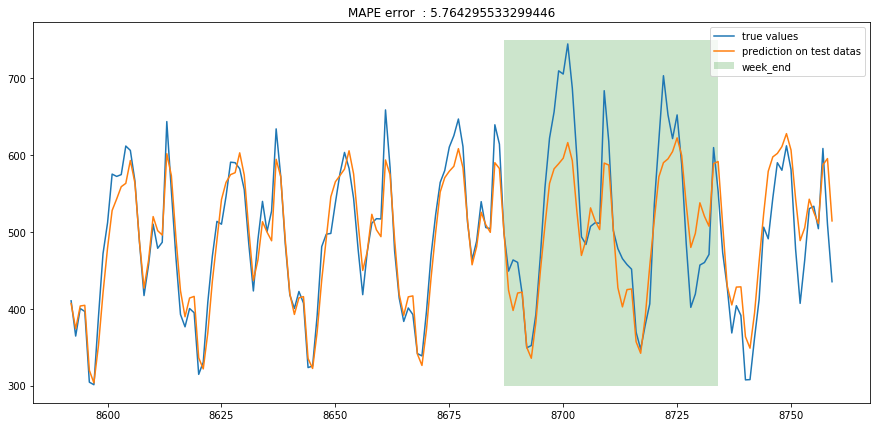

In [42]:
test_x = df.axes[0][-24*7:]

#--------------------------
tester = df['puissance'].values[-24*7-step:]

tester_x, dum = prepare_data(tester, step)
pred_mlp = []
for i in range(24*7) :
    pred_test= model.predict(tester_x[:1])
    pred_mlp.append(pred_test[0])
    tester_x[0][:-1] = tester_x[0][1:]
    tester_x[0][-1] = pred_test[0]

print(len(test_x),len(pred_mlp))
plt.title('MAPE error  : '+str(mape(tester[step:],pred_mlp)))
plt.plot(test_x, tester[step:],label='true values')
plt.plot(test_x,pred_mlp,label='prediction on test datas')
plt.fill_between(test_x, 300, 750, where=tester_we[step:] == True,facecolor='green', alpha=0.2,label='week_end')
plt.legend()
plt.show()

# Mixe des deux méthodes

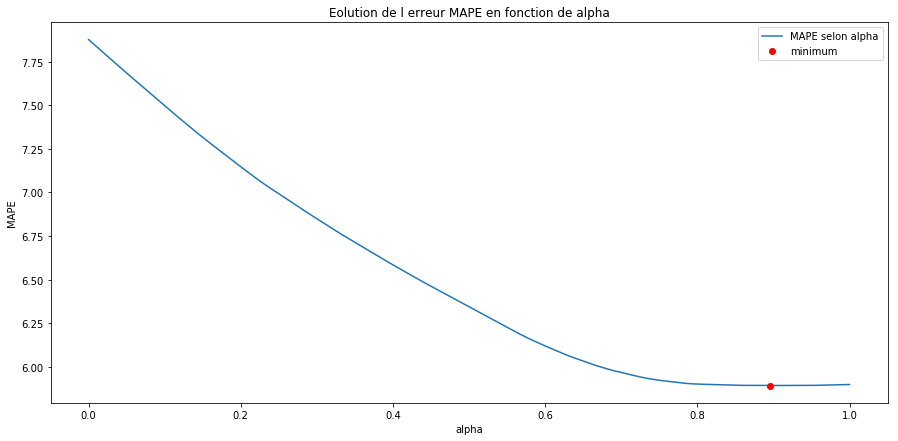

position du min :  179
Le mape est  5.893160842700783  pour alpha =  0.895


In [91]:
alpha_tab = np.linspace(0,1,201)
alpha_mape = []
for alpha in alpha_tab : 
    convex_sol = alpha*np.array(pred_mlp) + (1-alpha)*predictions_ARMA
    alpha_mape.append(mape(df[-24*7:]['puissance'],convex_sol))
plt.title('Eolution de l erreur MAPE en fonction de alpha')
plt.plot(alpha_tab,alpha_mape,label='MAPE selon alpha')
plt.plot(alpha_tab[np.argmin(alpha_mape)],alpha_mape[np.argmin(alpha_mape)],'ro',label='minimum')
plt.xlabel('alpha')
plt.ylabel('MAPE')
plt.legend()
plt.show()
best_alpha = alpha_tab[np.argmin(alpha_mape)]
print('position du min : ',np.argmin(alpha_mape))
print('Le mape est ',alpha_mape[np.argmin(alpha_mape)],' pour alpha = ',best_alpha)

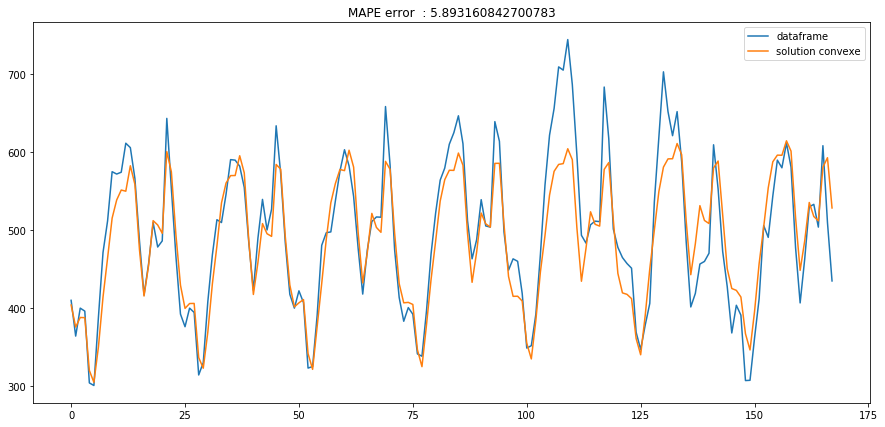

In [92]:
convex_sol = best_alpha*np.array(pred_mlp) + (1-best_alpha)*predictions_ARMA
plt.title('MAPE error  : '+str(mape(true_value,convex_sol)))
plt.plot(true_value,label='dataframe')
plt.plot(convex_sol,label='solution convexe')
plt.legend()
plt.show()

# Prédictions sur une semaine :

## Partie ARMA :

In [11]:
from statsmodels.tsa.arima_model import ARIMA
df_train = df_trend.copy()
modelARMA = ARIMA(df_train, order=(24,0,23))
results_ARMA = modelARMA.fit(disp=1) 
print('fin')

/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fin


/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ulysse/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


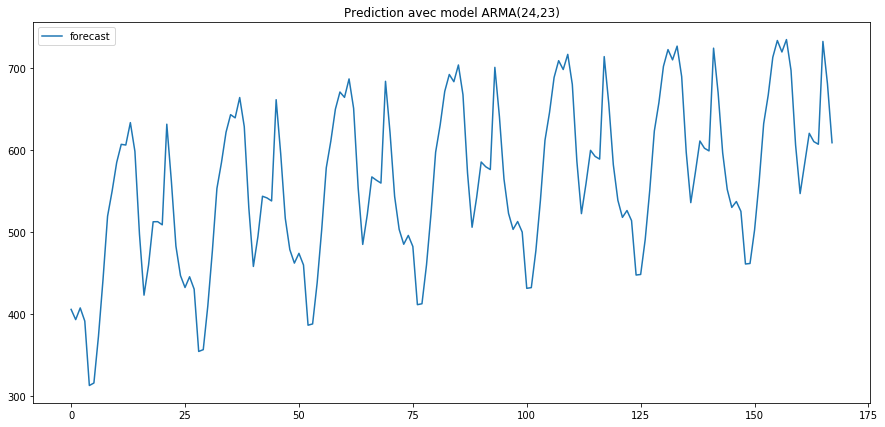

In [13]:
pred = results_ARMA.forecast(24*7)

taille = len(df)
x_pred = np.linspace(taille,taille+24*7,24*7)

vec_trend = approx_ma(x_pred)
predictions_ARMA = np.array(pred[0]) + np.array(vec_trend)

plt.plot(predictions_ARMA,label='forecast')
plt.title('Prediction avec model ARMA(24,23)')
plt.legend()
plt.show()

## Partie Réseau de neurones

In [43]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(13)

begin_train_data = 41*24*7 #int(len(df)-24*7-24*7*10)   #On entraine sur 15 semaine car c est ce que l'on a trouvé de mieux
end_train_data = int(len(df))


trainer = df['puissance'].values[begin_train_data:end_train_data]
step = 24*3

train_x, train_y = prepare_data(trainer, step)

model = Sequential()
model.add(Dense(10, activation='relu', input_dim=step))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
ADAM = optimizers.Adam(lr=0.001)
model.compile(optimizer=ADAM, loss='mape')

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath="weightsPred.hdf5", verbose=0, monitor='loss', save_best_only=True)

history = model.fit(train_x, train_y, batch_size = 10, epochs=300,callbacks = [early_stop,checkpointer], verbose=1)
model.load_weights('weightsPred.hdf5')

Epoch 1/300
1800/1800 [==============================] - 0s 174us/step - loss: 18.5155
Epoch 2/300
1800/1800 [==============================] - 0s 74us/step - loss: 8.6573
Epoch 3/300
1800/1800 [==============================] - 0s 80us/step - loss: 7.5143
Epoch 4/300
1800/1800 [==============================] - 0s 73us/step - loss: 6.9158
Epoch 5/300
1800/1800 [==============================] - 0s 73us/step - loss: 6.4310
Epoch 6/300
1800/1800 [==============================] - 0s 70us/step - loss: 6.3928
Epoch 7/300
1800/1800 [==============================] - 0s 83us/step - loss: 5.8719
Epoch 8/300
1800/1800 [==============================] - 0s 100us/step - loss: 5.4307
Epoch 9/300
1800/1800 [==============================] - 0s 85us/step - loss: 5.6391
Epoch 10/300
1800/1800 [==============================] - 0s 78us/step - loss: 5.3262
Epoch 11/300
1800/1800 [==============================] - 0s 68us/step - loss: 5.0695
Epoch 12/300
1800/1800 [==============================] - 0s

1800/1800 [==============================] - 0s 64us/step - loss: 3.4873
Epoch 97/300
1800/1800 [==============================] - 0s 62us/step - loss: 3.4364
Epoch 98/300
1800/1800 [==============================] - 0s 60us/step - loss: 3.4796
Epoch 99/300
1800/1800 [==============================] - 0s 64us/step - loss: 3.5887
Epoch 100/300
1800/1800 [==============================] - 0s 63us/step - loss: 3.4293
Epoch 101/300
1800/1800 [==============================] - 0s 64us/step - loss: 3.5015
Epoch 102/300
1800/1800 [==============================] - 0s 63us/step - loss: 3.3712
Epoch 103/300
1800/1800 [==============================] - 0s 67us/step - loss: 3.4789
Epoch 104/300
1800/1800 [==============================] - 0s 64us/step - loss: 3.6184
Epoch 105/300
1800/1800 [==============================] - 0s 61us/step - loss: 3.4662
Epoch 106/300
1800/1800 [==============================] - 0s 62us/step - loss: 3.5509
Epoch 107/300
1800/1800 [==============================] - 0

In [44]:
model.evaluate(train_x, train_y, verbose=1)

1800/1800 [==============================] - 0s 51us/step


3.2132441075642904

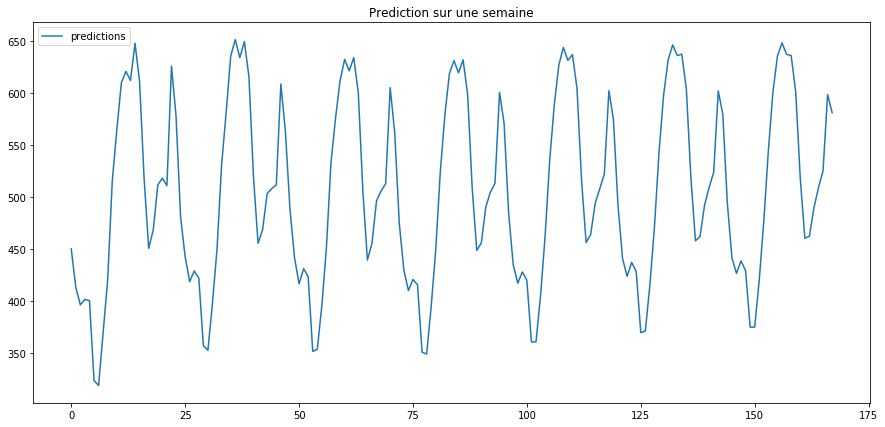

In [45]:
tester = df['puissance'].values[-1-step:]

tester_x, dum = prepare_data(tester, step)
pred_test_tot = []
#tester_x.append([0])
for i in range(24*7) :
    pred_test= model.predict(tester_x[:1])
    pred_test_tot.append(pred_test[0])
    tester_x[0][:-1] = tester_x[0][1:]
    tester_x[0][-1] = pred_test[0]

plt.title('Prediction sur une semaine')
plt.plot(pred_test_tot,label='predictions')
#plt.fill_between(test_x, 300, 750, where=tester_we[step:] == True,facecolor='green', alpha=0.2,label='week_end')
plt.legend()
plt.show()